In [1]:
import numpy as np
import json
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import multiprocessing
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
import pickle
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow
from tensorflow.python.keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from keras.optimizers import Adam
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import pandas as pd
from matplotlib import pyplot as plt
import sys
from scipy import io
from scipy import stats
# gradient boosted trees tend to do well on problems like this

BIDS_path = 'C:\\Users\\ICN_admin\\Documents\\BIDS\\'
subject_id = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
out_path = 'C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\dat\\'

def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]

def create_model():
    #start the model making process and create our first layer
    model = Sequential()
    model.add(Dense(num_input_nodes, input_shape=(40,), activation=activation
                   ))
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
    #add our classification layer.
    model.add(Dense(1,activation='linear'))

    #setup our optimizer and compile
    adam = Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='mean_squared_error',
                 metrics=['mse'])
    return model

space_NN = [Real(low=1e-4, high=1e-2, prior='log-uniform', name='learning_rate'),
              Integer(low=1, high=3, name='num_dense_layers'),
              Integer(low=1, high=10, prior='uniform', name='num_input_nodes'),
              Integer(low=1, high=10, name='num_dense_nodes'),
              Categorical(categories=['relu', 'tanh'], name='activation')
             ]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space_NN)
def objective(**params):
    print(params)

    global learning_rate
    learning_rate=params["learning_rate"]
    global num_dense_layers
    num_dense_layers=params["num_dense_layers"]
    global num_input_nodes
    num_input_nodes=params["num_input_nodes"]
    global num_dense_nodes
    num_dense_nodes=params["num_dense_nodes"]
    global activation
    activation=params["activation"]



    model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=300, verbose=0)

    cv_res = cross_val_score(model, X_time, y_time, cv=2, n_jobs=1, scoring="r2")

    #kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

    #cv_res = cross_val_score(reg, X_time, y_time, cv=3, n_jobs=-1,
    #                                scoring="r2")
    cv_res[np.where(cv_res < 0)[0]] = 0
    return -np.mean(cv_res)
    #return -cv_result['test-r2-mean'].iloc[-1]


Using TensorFlow backend.


In [2]:
def get_movement_idx(ch, mov_channels, Con=True):
    mov_idx = 0
    if len(mov_channels) > 1:    
        if Con is True:
            if ("RIGHT" in ch and "LEFT" in mov_channels[0]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "LEFT" in mov_channels[1]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[1]):
                mov_idx = 1
        else:
            if ("RIGHT" in ch and "RIGHT" in mov_channels[0]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "RIGHT" in mov_channels[1]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[1]):
                mov_idx = 1
    return mov_idx

In [3]:
def get_x_y_c(dict_ch, ind_, Con=True, return_z=False):
    
    channels = list(dict_ch.keys())
    x_choord = np.zeros(len(ind_))
    y_choord = np.zeros(len(ind_))
    z_choord = np.zeros(len(ind_))
    c_ = np.zeros(len(ind_))
    for idx, ind_ch in enumerate(ind_): 
        choord = np.squeeze(np.array(dict_ch[channels[ind_ch]]["choords"]))
        x_choord[idx] = choord[0]
        y_choord[idx] = choord[1]
        z_choord[idx] = choord[2]
        
        #wähle den contralateralen channel aus
        #mov_channels = dict_ch[channels[ind_ch]]['mov_ch']

        #mov_idx = get_movement_idx(channels[ind_ch], mov_channels, Con)

        #c_[idx] = dict_ch[channels[ind_ch]]["res_"+mov_channels[mov_idx]]["R2"]
    #if return_z is True:
    #    return x_choord, y_choord, z_choord#, c_
    return x_choord, y_choord#, c_

In [4]:
def get_modalitities(XGB_res):
    ecog_con_RF = []; ecog_con_RF_P = []; 
    ecog_ips_RF = []; ecog_ips_RF_P = []
    stn_con_RF = []; stn_con_RF_P = []
    stn_ips_RF = []; stn_ips_RF_P = []
    for patient in subject_id:
        channels = list(XGB_res[patient].keys())
        patient_ecog_con = []; patient_ecog_ips = []; patient_stn_con = []; patient_stn_ips = []
        patient_ecog_con_P = []; patient_ecog_ips_P = []; patient_stn_con_P = []; patient_stn_ips_P = []
        for ch in channels:
            if 'ECOG' in ch:
                patient_ecog_con.append(XGB_res[patient][ch]["r2_con"])
                patient_ecog_ips.append(XGB_res[patient][ch]["r2_ips"])
                patient_ecog_con_P.append(XGB_res[patient][ch]["param_con"])
                patient_ecog_ips_P.append(XGB_res[patient][ch]["param_ips"])
            elif 'STN' in ch:
                patient_stn_con.append(XGB_res[patient][ch]["r2_con"])
                patient_stn_ips.append(XGB_res[patient][ch]["r2_ips"])
                patient_stn_con_P.append(XGB_res[patient][ch]["param_con"])
                patient_stn_ips_P.append(XGB_res[patient][ch]["param_ips"])
        
        max_arg = np.argmax(patient_ecog_con)
        ecog_con_RF.append(patient_ecog_con[max_arg])
        ecog_con_RF_P.append(patient_ecog_con_P[max_arg])
        
        max_arg = np.argmax(patient_ecog_ips)
        ecog_ips_RF.append(patient_ecog_ips[max_arg])
        ecog_ips_RF_P.append(patient_ecog_ips_P[max_arg])
        
        
        max_arg = np.argmax(patient_stn_con)
        stn_con_RF.append(patient_stn_con[max_arg])
        stn_con_RF_P.append(patient_stn_con_P[max_arg])
        
        max_arg = np.argmax(patient_stn_ips)
        stn_ips_RF.append(patient_stn_ips[max_arg])
        stn_ips_RF_P.append(patient_stn_ips_P[max_arg])
    res = {
        "ECOG_CON_R2" : ecog_con_RF, 
        "ECOG_IPS_R2" : ecog_ips_RF, 
        "STN_CON_R2" : stn_con_RF, 
        "STN_IPS_R2" : stn_ips_RF, 
        "ECOG_CON_P" : ecog_con_RF_P, 
        "ECOG_IPS_P" : ecog_ips_RF_P, 
        "STN_CON_P" : stn_con_RF_P, 
        "STN_IPS_P" : stn_ips_RF_P, 
    }
        
    return res

In [5]:
with open('nn_tot.p', 'rb') as handle:
    NN_res = pickle.load(handle)
with open('LM_tot.p', 'rb') as handle:
    LM_res = pickle.load(handle)
with open('XGB_tot.p', 'rb') as handle:
    XGB_res = pickle.load(handle)

In [6]:
res_XGB = get_modalitities(XGB_res)
res_LM = get_modalitities(LM_res)
res_NN = get_modalitities(NN_res)

In [7]:
faces = io.loadmat('faces.mat')
Vertices = io.loadmat('Vertices.mat')
grid = io.loadmat('grid.mat')['grid']
stn_surf = io.loadmat('STN_surf.mat')
x_ = stn_surf['vertices'][::2,0]
y_ = stn_surf['vertices'][::2,1]
x_ecog = Vertices['Vertices'][::1,0]
y_ecog = Vertices['Vertices'][::1,1]
x_stn = stn_surf['vertices'][::1,0]
y_stn = stn_surf['vertices'][::1,1]

In [8]:
def get_c_from_RES(ind_ECOG, channels, subject_id_, Con_):
    c = []
    for ch in ind_ECOG:
        if Con_ is True:
            c.append(XGB_res[subject_id_][channels[ch]]["r2_con"])
        else:
            c.append(XGB_res[subject_id_][channels[ch]]["r2_ips"])
    return c

In [9]:
out_path = "C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\dat\\"

In [10]:
def plot_all_in_one(out_path = "C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\dat\\"):
    height_STN = 1
    height_ECOG = 2.5*height_STN
    fig, axes = plt.subplots(2,2, facecolor=(0,0,0), gridspec_kw={'height_ratios': [height_ECOG, height_STN]}, \
                             figsize=(14,9))#, dpi=300)
    for idx in range(2):
        if idx == 0:
            Con_ = True
        else:
            Con_ = False
        axes[0, idx].scatter(x_ecog, y_ecog, c="gray", s=0.001)
        axes[1, idx].scatter(x_stn, y_stn, c="gray", s=0.001)
        for sub_idx, subject_id_ in enumerate(subject_id):  
            print(subject_id_)
            with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
                dict_ch = json.load(fp)
            channels = list(dict_ch.keys())
            ind_ECOG = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("ECOG")]
            ind_STN = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("STN")]
            if subject_id_ != '004':
                x,y = get_x_y_c(dict_ch, ind_ECOG, Con=Con_)
                c = get_c_from_RES(ind_ECOG, channels, subject_id_, Con_=Con_)
            else:
                x,y = get_x_y_c(dict_ch, ind_ECOG, Con= not Con_)
                c = get_c_from_RES(ind_ECOG, channels, subject_id_, Con_= not Con_)
            pos_ecog = axes[0, idx].scatter(x, y, c=c, s=10, alpha=0.8, cmap='viridis')
            
            if subject_id_ != '004':
                x,y = get_x_y_c(dict_ch, ind_STN, Con=Con_)
                c = get_c_from_RES(ind_STN, channels, subject_id_, Con_=Con_)
            else:
                x,y = get_x_y_c(dict_ch, ind_STN, Con= not Con_)
                c = get_c_from_RES(ind_STN, channels, subject_id_, Con_= not Con_)
            if len(c) == 4:
                c_restructure = [c[0], (c[0]+c[1])/2, (c[1]+c[2])/2, c[2]]
            elif len(c) == 8:
                c_restructure = [c[0], (c[0]+c[1])/2, (c[1]+c[2])/2, c[2], 
                                c[4], (c[4]+c[5])/2, (c[5]+c[6])/2, c[6]]
            pos_stn = axes[1, idx].scatter(x, y, c=c_restructure, s=10, alpha=0.8, cmap='viridis')
            cbar_stn = fig.colorbar(pos_stn, ax=axes[1, idx]); pos_stn.set_clim(0,0.7); cbar_stn.remove()
            cbar_ecog = fig.colorbar(pos_ecog, ax=axes[0, idx]); pos_ecog.set_clim(0,0.7); cbar_ecog.remove()

        if idx == 1:
            cbar_ecog = fig.colorbar(pos_ecog, ax=axes[0, idx]); pos_ecog.set_clim(0,0.7); 
            cbar_ecog.set_label('R²', color="white")
            cbar_ecog.ax.tick_params(axis='y', color='white')
            cbar_ecog.ax.set_yticklabels(labels=np.round(cbar_ecog.get_ticks(),2),color='white')
            cbar_ecog.outline.set_edgecolor('white')
        if idx == 0:
            axes[0, idx].set_title('contralateral performance', color='white')
        else:
            axes[0, idx].set_title('ipsilateral performance', color='white')
        axes[0, idx].axes.set_aspect('equal', anchor='C')
        axes[0, idx].set_facecolor((0,0,0))
        axes[1, idx].axes.set_aspect('equal', anchor='C')
        axes[1, idx].set_facecolor((0,0,0))


000
001
004
005
006
007
008
009
010
013
014
000
001
004
005
006
007
008
009
010
013
014


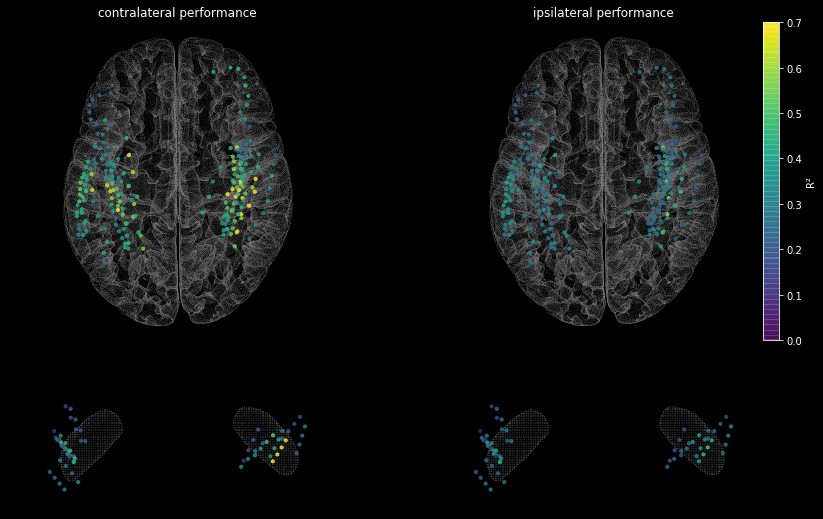

In [11]:
plot_all_in_one()

### Plot individual patients

In [11]:
#4037, 4065, 4011 KEINE STN DATEN 
#011, 015, 002
def plot_all_patients(out_path = "C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\dat\\", Con=True):
    height_STN = 1
    height_ECOG = 2.5*height_STN
    rows=6; columns = 4
    fig, axes = plt.subplots(rows,columns, facecolor=(0,0,0), gridspec_kw={'height_ratios': [height_ECOG, height_STN]*3}, \
                             figsize=(17,17))#, dpi=700)
    x_cnt_ECOG, y_cnt_ECOG, x_cnt_STN, y_cnt_STN = 0,0,0,1

    for sub_idx, subject_id_ in enumerate(subject_id):    
        if subject_id_ == '016' and Con is False:
            axes[y_cnt_STN, x_cnt_STN].axes.set_aspect('equal', anchor='C')
            axes[y_cnt_STN, x_cnt_STN].set_facecolor((0,0,0))
            axes[y_cnt_ECOG, x_cnt_ECOG].axes.set_aspect('equal', anchor='C')
            axes[y_cnt_ECOG, x_cnt_ECOG].set_facecolor((0,0,0))
            continue
        with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)
        channels = list(dict_ch.keys())
        ind_ECOG = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("ECOG")]
        ind_STN = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("STN")]


        axes[y_cnt_ECOG, x_cnt_ECOG].scatter(x_ecog, y_ecog, c="gray", s=0.0001)
        axes[y_cnt_ECOG, x_cnt_ECOG].set_title('sub'+subject_id_, color='white')
        
        if subject_id_ != '004':
            x,y = get_x_y_c(dict_ch, ind_ECOG, Con=Con)
            c = get_c_from_RES(ind_ECOG, channels, subject_id_, Con_=Con)
        else:
            x,y = get_x_y_c(dict_ch, ind_ECOG, Con= not Con)
            c = get_c_from_RES(ind_ECOG, channels, subject_id_, Con_= not Con)
        
        if subject_id_ == '001' or subject_id_ == '006':
            pos_ecog = axes[y_cnt_ECOG, x_cnt_ECOG].scatter(x, y, c=c, s=5)
        else:
            pos_ecog = axes[y_cnt_ECOG, x_cnt_ECOG].scatter(x, y, c=c, s=15)

        cbar_ecog = fig.colorbar(pos_ecog, ax=axes[y_cnt_ECOG, x_cnt_ECOG]); pos_ecog.set_clim(0,0.7); cbar_ecog.remove()
        
        pos_stn = axes[y_cnt_STN, x_cnt_STN].scatter(x_stn, y_stn, c="gray", s=0.0001)
        
        if subject_id_ != '004':
            x,y = get_x_y_c(dict_ch, ind_STN, Con)
            c = get_c_from_RES(ind_STN, channels, subject_id_, Con_=Con)
        else:
            x,y = get_x_y_c(dict_ch, ind_STN, not Con)
            c = get_c_from_RES(ind_STN, channels, subject_id_, Con_=not Con)
            
        if len(c) == 4:
            c_restructure = [c[0], (c[0]+c[1])/2, (c[1]+c[2])/2, c[2]]
        elif len(c) == 8:
            c_restructure = [c[0], (c[0]+c[1])/2, (c[1]+c[2])/2, c[2], 
                                c[4], (c[4]+c[5])/2, (c[5]+c[6])/2, c[6]]
        pos_stn = axes[y_cnt_STN, x_cnt_STN].scatter(x, y, c=np.array(c_restructure), s=15)
 
        cbar_stn = fig.colorbar(pos_stn, ax=axes[y_cnt_STN, x_cnt_STN]); pos_stn.set_clim(0,0.7); cbar_stn.remove()

        axes[y_cnt_STN, x_cnt_STN].axes.set_aspect('equal', anchor='C')
        axes[y_cnt_STN, x_cnt_STN].set_facecolor((0,0,0))
        axes[y_cnt_ECOG, x_cnt_ECOG].axes.set_aspect('equal', anchor='C')
        axes[y_cnt_ECOG, x_cnt_ECOG].set_facecolor((0,0,0))

        x_cnt_ECOG = x_cnt_ECOG + 1
        x_cnt_STN = x_cnt_ECOG

        if x_cnt_ECOG == 4:
            y_cnt_ECOG = y_cnt_ECOG + 2
            y_cnt_STN = y_cnt_ECOG + 1
            x_cnt_ECOG, x_cnt_STN = 0, 0
    
    axes[4, 3].set_facecolor((0,0,0)); axes[4, 3].set_axis_off()
    axes[5, 3].set_facecolor((0,0,0)); axes[5, 3].set_axis_off()
    #axes[6, 1].set_facecolor((0,0,0)); axes[6, 1].set_axis_off()
    #axes[6, 2].set_facecolor((0,0,0)); axes[6, 2].set_axis_off()
    #axes[6, 3].set_facecolor((0,0,0)); axes[6, 3].set_axis_off()
    #axes[7, 1].set_facecolor((0,0,0)); axes[7, 1].set_axis_off()
    #axes[7, 2].set_facecolor((0,0,0)); axes[7, 2].set_axis_off()
    #axes[7, 3].set_facecolor((0,0,0)); axes[7, 3].set_axis_off()

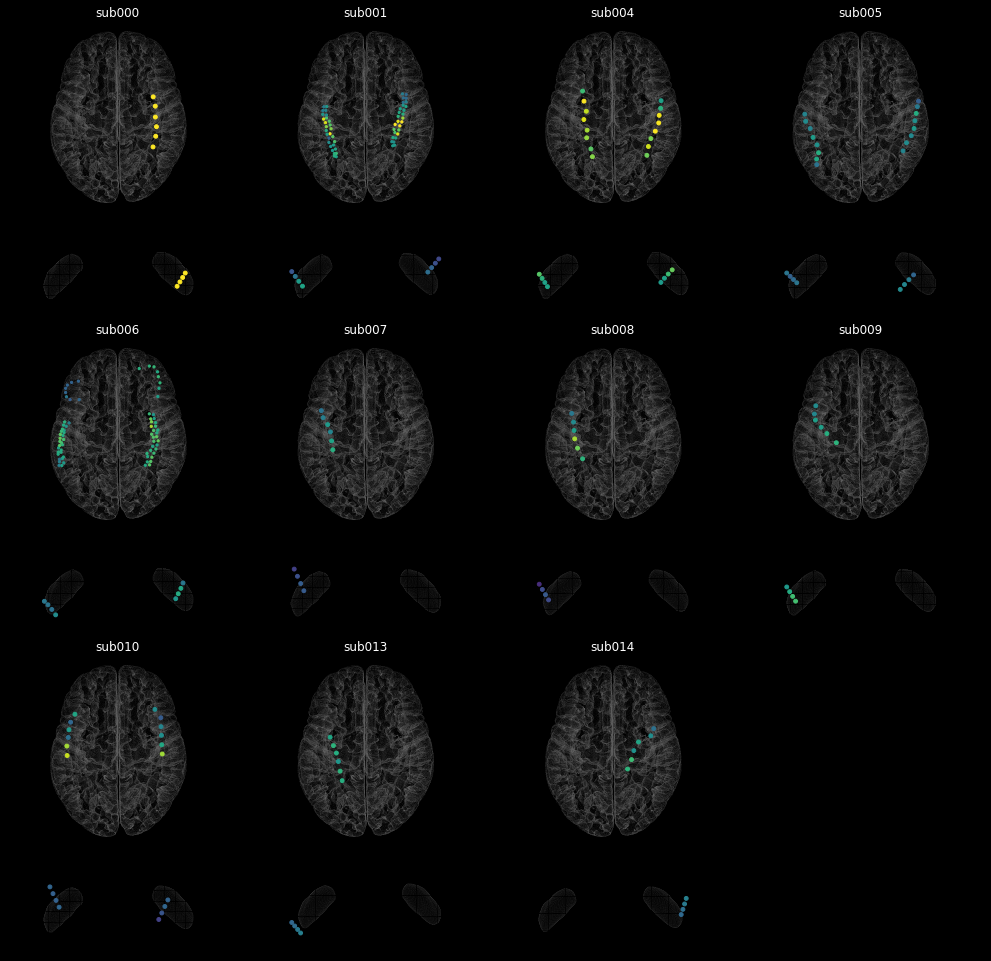

In [13]:
plot_all_patients(Con=True)

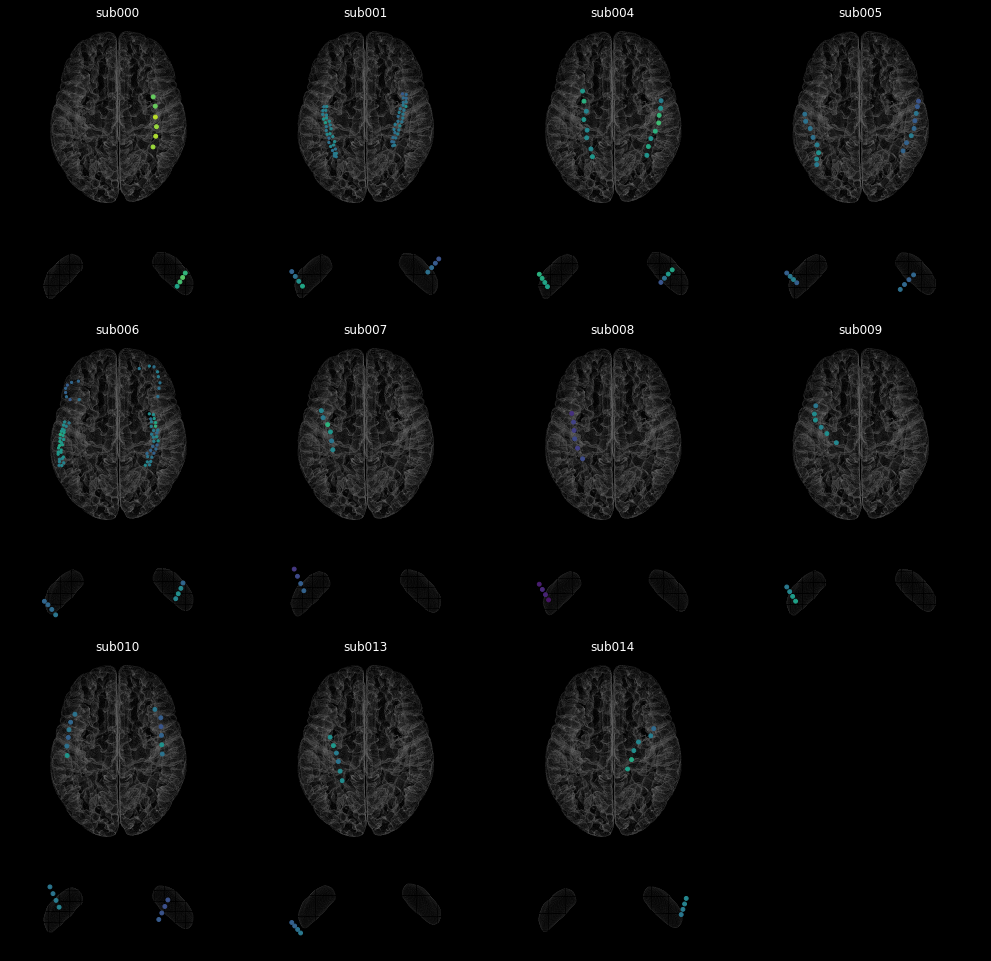

In [14]:
plot_all_patients(Con=False)